<div align='center'><font size="5" color='#353B47'>Liver Tumour Segmentation</font></div>
<div align='center'><font size="4" color="#353B47">Using U-Net</font></div>

**<font color="#5963ab" size="4">Objective</font>**

> This notebook is dedicated to implement Liver Tumour Segmentation using U-Net algorithm, a specialized convolutional neural network architecture, to perform a task of image segmentation accurately and efficiently.

## <div id="summary">Table of contents</div>

**<font size="2"><a href="#chap1">1. Introduction</a></font>**
**<br><font size="2"><a href="#chap2">2. Import</a></font>**
**<br><font size="2"><a href="#chap3">3. Data Preprocessing</a></font>**
**<br><font size="2"><a href="#chap4">4. Data Generator, Data Augmentation </a></font>**
**<br><font size="2"><a href="#chap5">5. Training Model</a></font>**
**<br><font size="2"><a href="#chap6">6. Inference</a></font>**

# <div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Introduction</h1></div>

**<font color="#5963ab" size="4">About Data</font>**

> The data considered for liver tumours is an extract from the original dataset LiTS—Liver Tumour Segmentation Challenge (LiTS17), organised in conjunction with ISBI 2017 and MICCAI 2017. CT scans are converted to jpg (image) files for easier data processing and feeding to the model.
>
>The dataset is made of one-third of volumes, and in slices, every second slice is extracted to convert into jpg files.

**<font color="#5963ab" size="4">U-Net</font>**

> The U-Net is a type of convolutional neural network (CNN) that's specifically designed for swift and accurate segmentation of images.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

> The illustration depicts the U-Net architecture, using 32x32 pixels at the lowest resolution as an example. In this diagram, each blue box represents a multi-channel feature map. The quantity of channels for each feature map is indicated above the corresponding box, while the spatial dimensions (x-y size) are indicated at the lower left corner of the box. Boxes in white denote feature maps that have been copied from a previous layer. The arrows present in the diagram symbolize various operations carried out in the architecture.
>
> Please note that while this illustration serves as an example of the U-Net architecture, the actual dimensions or layout of the layers can vary, depending on specific use cases or modifications to the architecture.

<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Import</h1></div>

## Importing Modules

In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# import system libs
import os
import random
from tqdm.notebook import tqdm

# import data handling tools
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

print ('Modules Loaded')


Modules Loaded


In [25]:
# Set parameters
IMAGE_SIZE = (256, 256)

## Data Directory Names

In [4]:
images = "C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiTS_dataset/images"
masks = "C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiTS_dataset/masks"

## Create DataFrame

In [5]:
# List all file names in the image folder 
image_paths = []
for root, dirs, files in os.walk(images):
    for file in files:
        file_path = os.path.join(root, file)  
        image_paths.append(file_path)
        
# Function for extracting volumn and slice numbers for sorting 
# def get_volume_and_slice_numbers(file_path):
#     # Extract volume and slice numbers from the file path
#     #parts = file_path.split('_')
#     parts = file_path.split('\\')[-1].split('_')
#     volume_number = int(parts[1].split('-')[1])
#     slice_number = int(parts[-1].split('.')[0])
#     return (volume_number, slice_number)

# Sort the image paths based on both volume and slice numbers
#image_paths.sort(key=get_volume_and_slice_numbers)

# Creating mask files list
mask_paths = [path.replace('images', 'masks').replace('.jpg', '_mask.jpg') for path in image_paths]

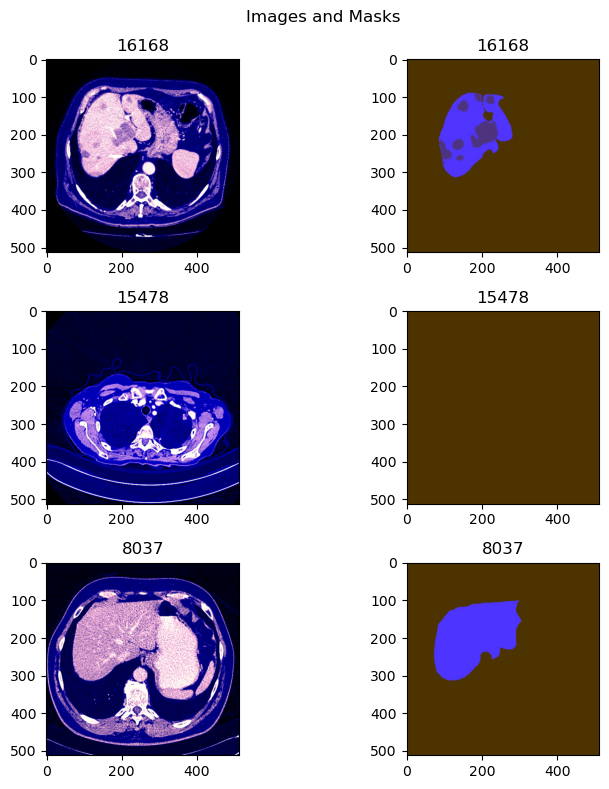

In [5]:
# Displaying random images and masks for data visualization
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
fig.suptitle("Images and Masks")
indices = []
for i in range(3):
    idx = np.random.choice(len(image_paths))
    indices.append(idx)
    img = imread(image_paths[idx])
    mask = imread(mask_paths[idx])

    axs[i, 0].imshow(img)
    axs[i, 0].set_title(str(idx)) #+"-"+str(df['diagnosis'][idx])

    axs[i, 1].imshow(mask)
    axs[i, 1].set_title(str(idx)) #+"-"+str(df['diagnosis'][idx])

plt.tight_layout()
plt.show()

As we can see here most of the maska are empty and act as a noise to our model. We need to remove them, for that we are going to check if the masks are empty or have liver or tumor to segregate them.

In [6]:
threshold_percentage = 0
def check_tumor(mask_path):
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    # Threshold the mask to identify tumor regions
    thresholded_mask = ((mask > 55) & (mask < 75)).astype(np.uint8)  # Tumor regions will be 1, others 0
    # Calculate the percentage of tumor pixels in the binary mask
    tumor_pixel_percentage = (np.sum(thresholded_mask == 1) / thresholded_mask.size) * 100
    # Check if the image contains tumor regions
    if (tumor_pixel_percentage > threshold_percentage):
        return '2'
    else:
        return '1'

In [7]:
def diagnosis(mask_path):
    # Check if the mask contains liver or tumor regions
    if (np.sum(imread(mask_path)) == 33554432):
        return '0'
    else:
        return (check_tumor(mask_path))

Using diagnosis and check_tumor we can know find whats in a mask. 
diagnosis function checks whether the mask is empty or not them sends to check_tumor function.
check_tumor function is designed to calculate the percentage of tumor present in every mask, if the percentage is more tham 0 then it classifies in to mask with tumor.

In [8]:
diagnosis_values = []  # To store the diagnosis values
for mask_path in tqdm(mask_paths, desc='Processing'):
    diagnosis_values.append(diagnosis(mask_path))

df = pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths, "diagnosis": diagnosis_values})
df.head()

Processing:   0%|          | 0/29356 [00:00<?, ?it/s]

image_path  \
0  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
1  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
2  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
3  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
4  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   

                                           mask_path diagnosis  
0  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         0  
1  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         0  
2  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         0  
3  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         0  
4  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         0

# <div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Data Preprocessing</h1></div>

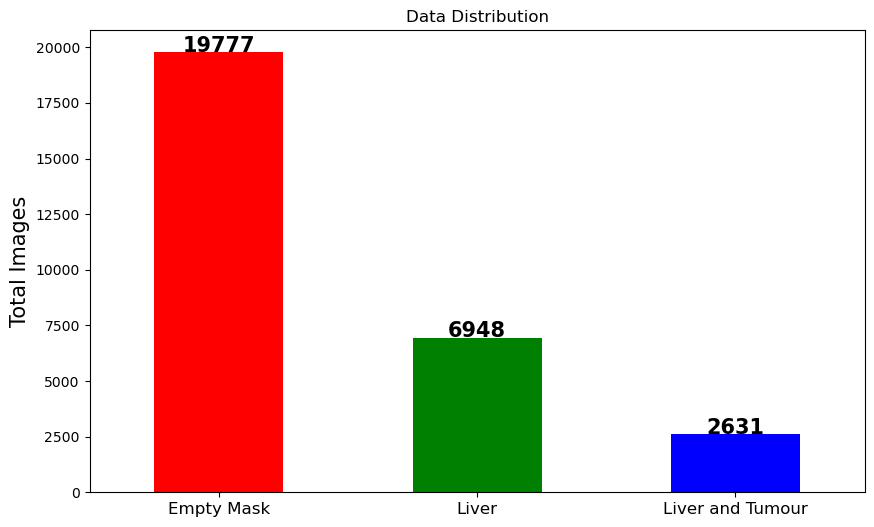

In [9]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['red','green', 'blue'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['Empty Mask', 'Liver','Liver and Tumour'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Visualize scans with Mask

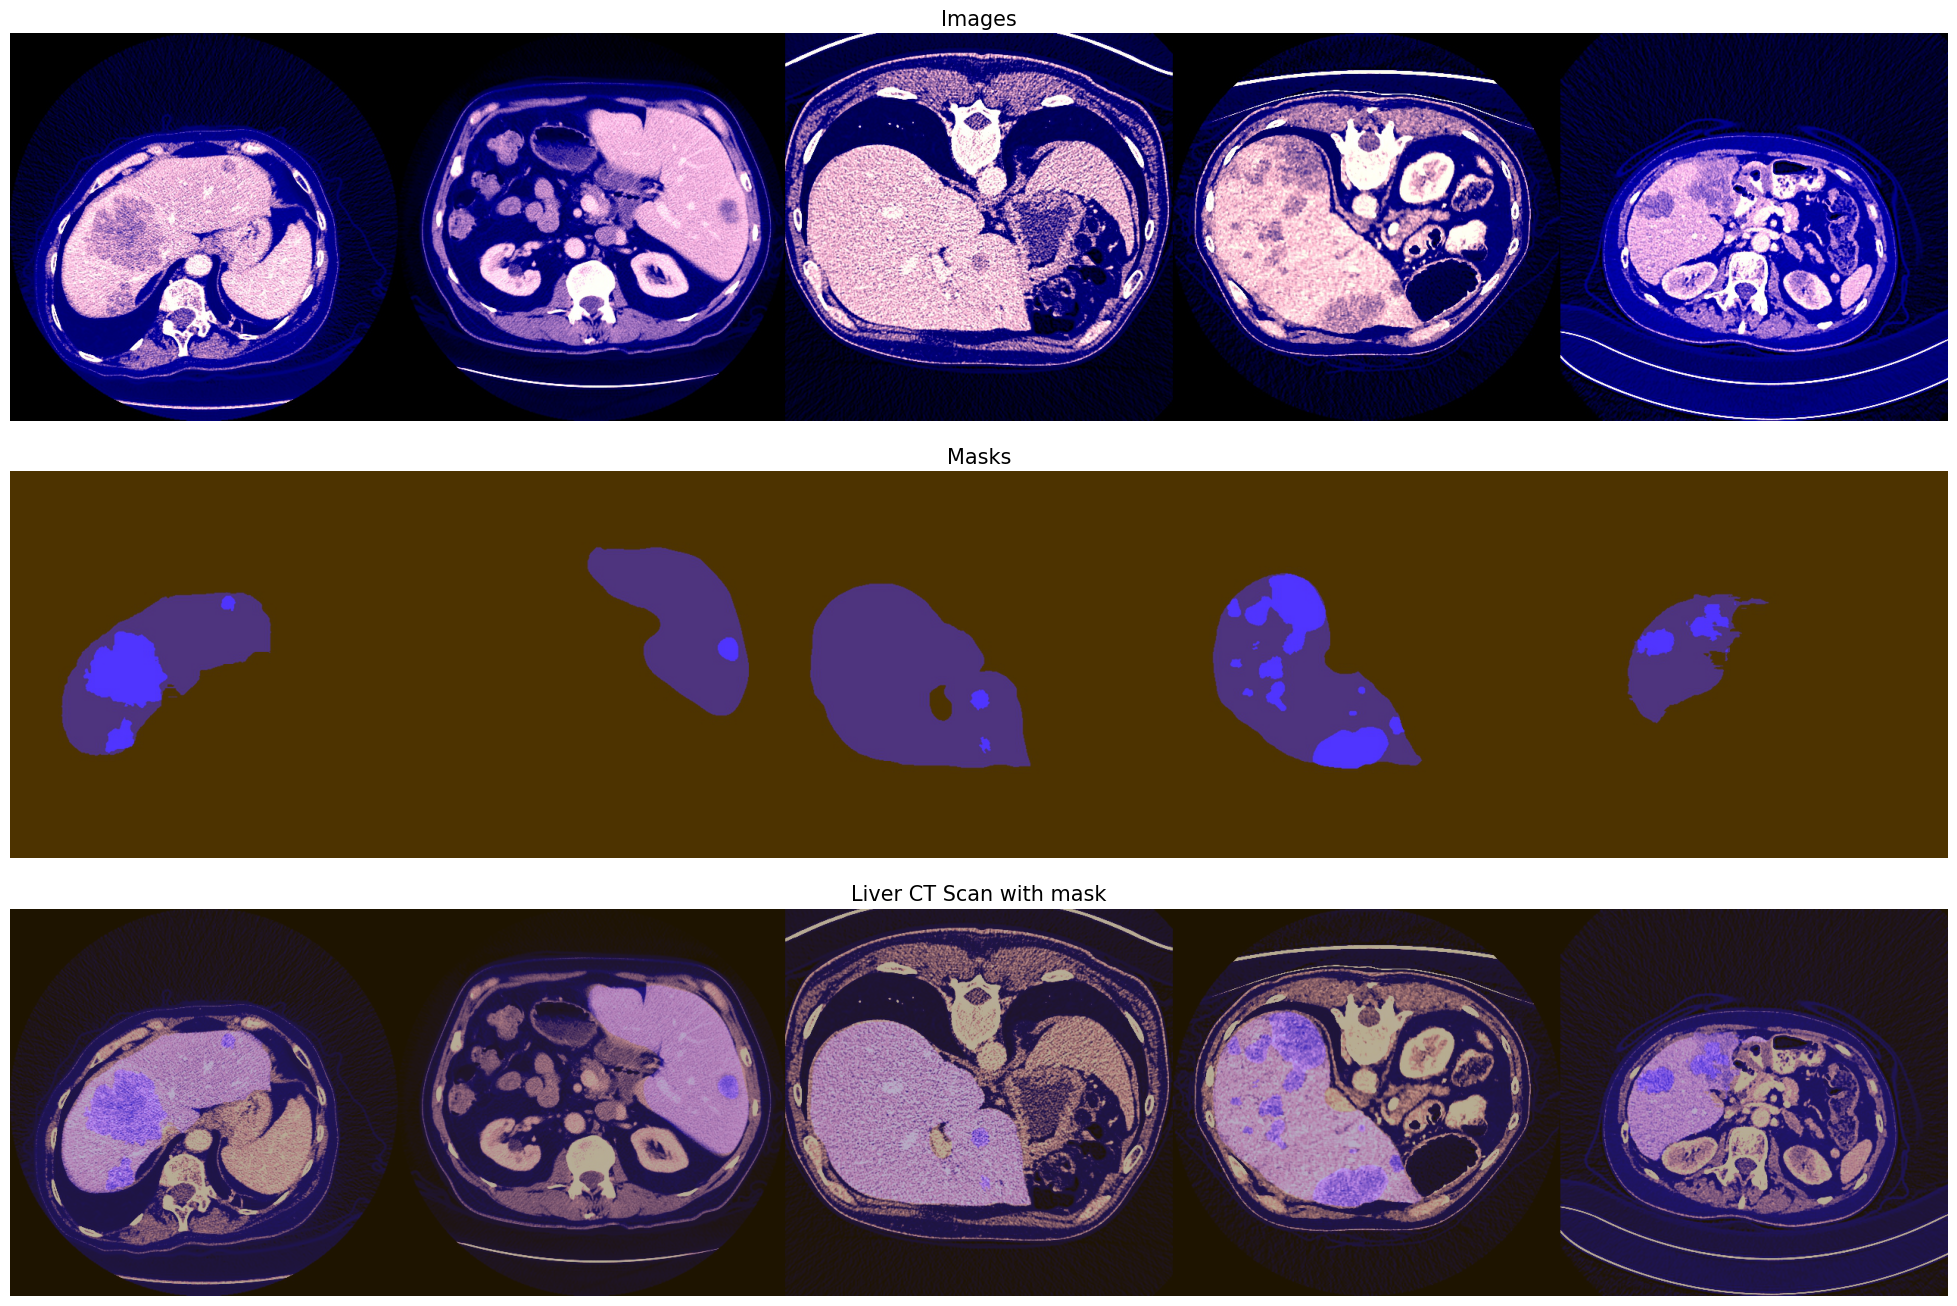

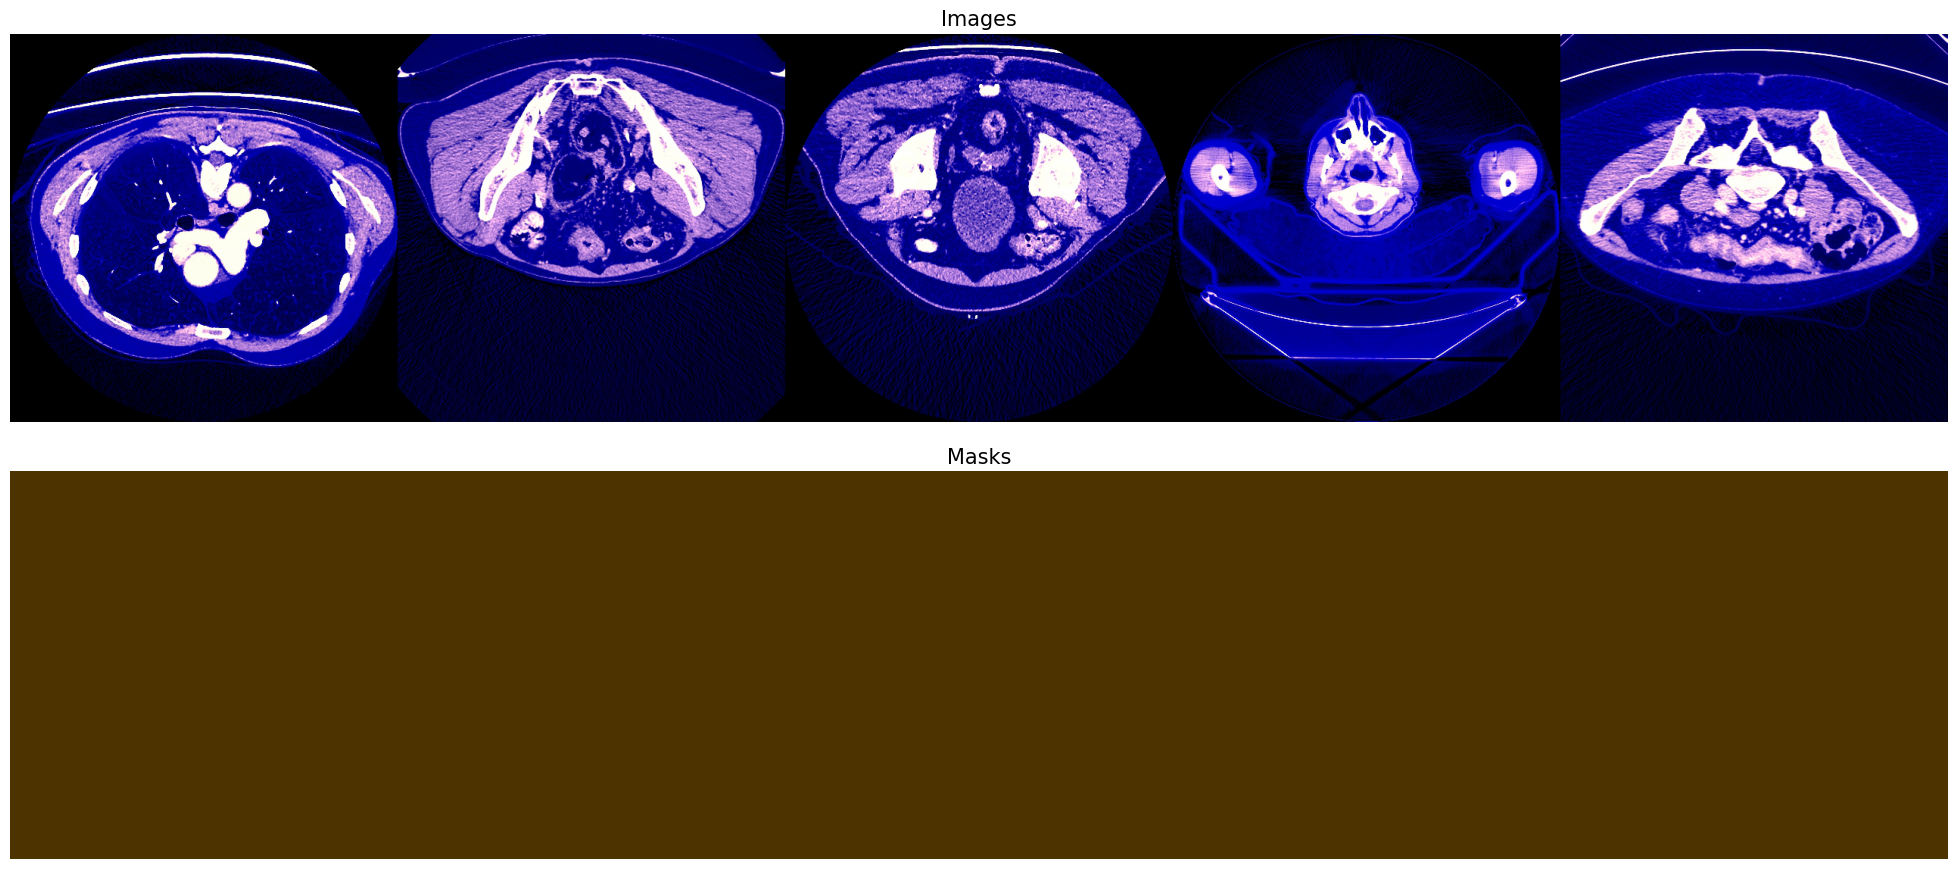

In [10]:
df_positive = df[df['diagnosis']== '2'].sample(5).values
df_negative = df[df['diagnosis']== '0'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = imread(data[0])
        mask = imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Liver CT Scan with mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

### Considering only masks with tumor

In [11]:
df = df[(df['diagnosis'] != '0')&(df['diagnosis'] != '1')]
df.reset_index(drop = True, inplace=True)

In [12]:
df.shape

(2631, 3)

In [13]:
df

image_path  \
0     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
1     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
2     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
3     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
4     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
...                                                 ...   
2626  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
2627  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
2628  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
2629  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   
2630  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...   

                                              mask_path diagnosis  
0     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
1     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
2     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
3     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
4     C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
...                                                 ...       ...  
2626  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
2627  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
2628  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
2629  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  
2630  C:/Users/20P61A6611/Downloads/MINI_PROJECT/LiT...         2  

[2631 rows x 3 columns]

### Train, Test, Validation Split
2631 images are split into train: 2000, test: 200, validation: 431
But First data is jumbled using sample(frac=1)

In [14]:
df = df.sample(frac=1,random_state = 32)

In [15]:
df_train = df[:2000]
df_test = df[2000:2200]
df_val = df[2200:]

In [16]:
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2000, 3)
(431, 3)
(200, 3)


# <div id="chap4"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Data Generator, Data Augmentation</h1></div>

In [17]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

# adjust_data function makes the masks with liver and tumor into only tumor,
# this converts the multi-class segmentation into binary segmentation, it also normalizes the images
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    new_mask=np.zeros(mask.shape)
    new_mask[mask > 0.30] = 1
    new_mask[mask <= 0.30] = 0
    mask = new_mask
    
    return (img, mask)

Found 200 validated image filenames.
Found 200 validated image filenames.
Batch 1, Images shape: (32, 256, 256, 3), Masks shape: (32, 256, 256, 1)


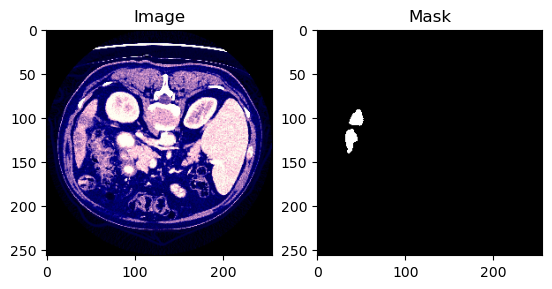

In [18]:
# Create the generator
batch_size = 32
data_generator = train_generator(
    batch_size=batch_size,
    data_frame=df_test,  
    aug_dict={},
)
for batch_idx, (images, masks) in enumerate(data_generator):
    print(f"Batch {batch_idx + 1}, Images shape: {images.shape}, Masks shape: {masks.shape}")
    plt.subplot(121)
    plt.imshow(images[0])
    plt.title("Image")
    plt.subplot(122)
    plt.imshow(masks[0], cmap='gray') 
    plt.title("Mask")
    plt.show()
    break

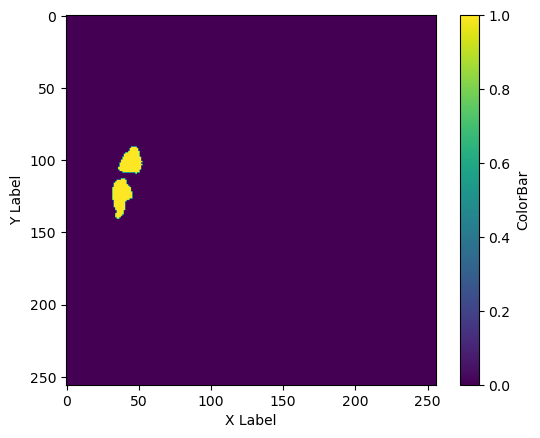

In [19]:
fig, ax = plt.subplots() 
shw = ax.imshow(masks[0]) 
bar = plt.colorbar(shw) 
plt.xlabel('X Label') 
plt.ylabel('Y Label') 
bar.set_label('ColorBar') 
plt.show() 

### Defining loss function and metrics

In [20]:
# Defining Loss function and metrics
smooth=1.
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# <div id="chap5"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Training U-Net</h1></div>

### Define UNet Model

In [22]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## Training

In [23]:
# Set parameters
EPOCHS = 55
BATCH_SIZE = 32
learning_rate = 1e-4

In [26]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                            train_generator_args,
                            target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                            dict(),
                            target_size=IMAGE_SIZE)
    
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# learning rate schedule
def lr_schedule(epoch):
    if epoch < 30:
        return 1e-4
    else:
        return 1e-5 

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, 
              loss=bce_dice_loss, 
              metrics=['accuracy', iou, dice_coef])

callbacks = [ModelCheckpoint('unet_seg.hdf5', verbose=0,
            save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', 
            factor=0.1, 
            patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', 
            restore_best_weights=True, patience=5),
            LearningRateScheduler(lr_schedule)]

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

                                                                                                  
 activation_10 (Activation)  (None, 32, 32, 512)          0         ['conv2d_10[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)          (None, 32, 32, 512)          2359808   ['activation_10[0][0]']       
                                                                                                  
 batch_normalization_5 (Bat  (None, 32, 32, 512)          2048      ['conv2d_11[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation_11 (Activation)  (None, 32, 32, 512)          0         ['batch_normalization_5[0][0]'
                                                                    ]                             
          

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

# <div id="chap6"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Inference</h1></div>

### Visualize the model performance

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    index_iou = np.argmax(val_iou)
    iou_highest = val_iou[index_iou]
    
    index_dice = np.argmax(val_dice)
    dice_highest = val_dice[index_dice]
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
plot_training(history)

## Evaluate the model

In [27]:
model = load_model("C:/Users/20P61A6611/Downloads/MINI_PROJECT/unet_seg.hdf5",compile = False)

model.compile(optimizer=opt, 
              loss=bce_dice_loss, 
              metrics=['accuracy', iou, dice_coef])

In [28]:
test_gen = train_generator(df_test, BATCH_SIZE, 
                            dict(),
                            target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Loss: ",results[0])
print("Accuracy: ",results[1])
print("Test IOU: ",results[2])
print("Test Dice Coefficent: ",results[3])

Found 200 validated image filenames.
Found 200 validated image filenames.


6/6 [==============================] - 93s 14s/step - loss: 0.1519 - accuracy: 0.9972 - iou: 0.7603 - dice_coef: 0.8636
Loss:  0.15185411274433136
Accuracy:  0.9972231388092041
Test IOU:  0.7602687478065491
Test Dice Coefficent:  0.8635578155517578


### Visualize the Result

In [29]:
# adjust_mask adjusting masks to display with only tumor
def adjust_mask(mask_path):
    mask = cv2.imread(mask_path, 0)       
    mask = cv2.resize(mask, IMAGE_SIZE, interpolation = cv2.INTER_NEAREST)
    mask = mask / 255.
    new_mask=np.zeros(mask.shape)
    new_mask[mask > 0.30] = 1
    new_mask[mask <= 0.30] = 0
    return new_mask

1/1 [==============================] - 2s 2s/step


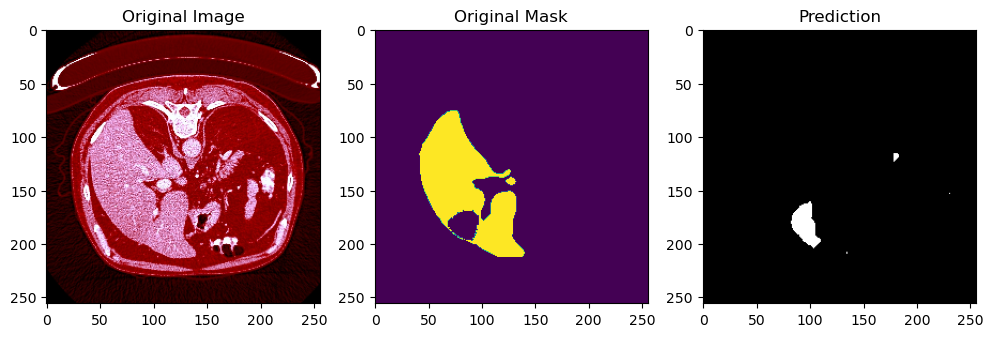

1/1 [==============================] - 1s 605ms/step


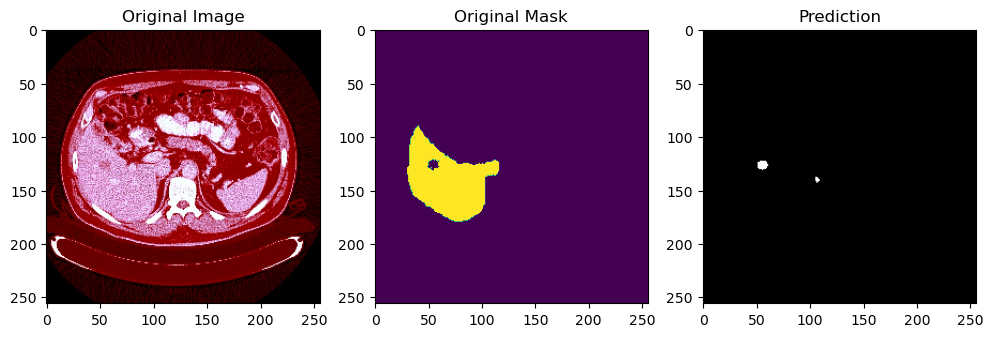

1/1 [==============================] - 1s 549ms/step


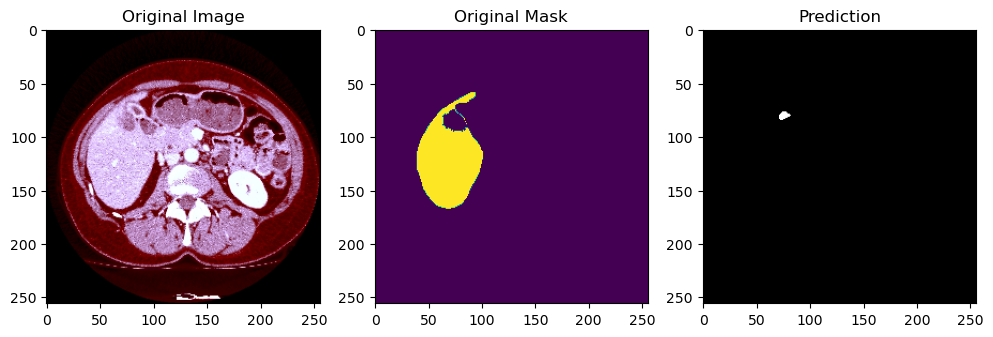

1/1 [==============================] - 0s 468ms/step


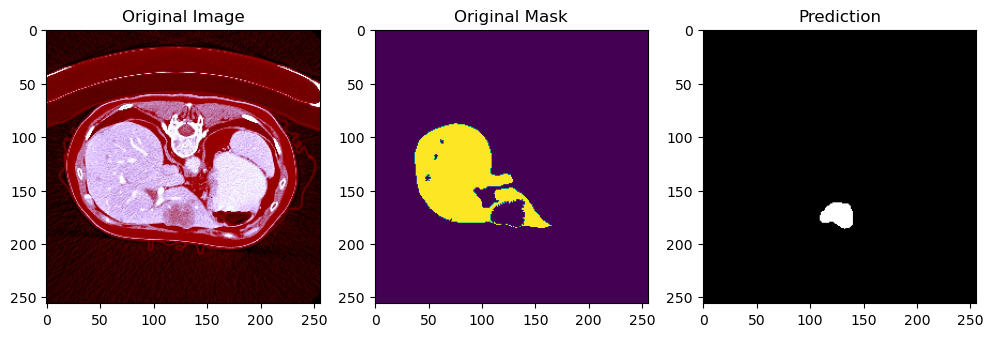

1/1 [==============================] - 0s 437ms/step


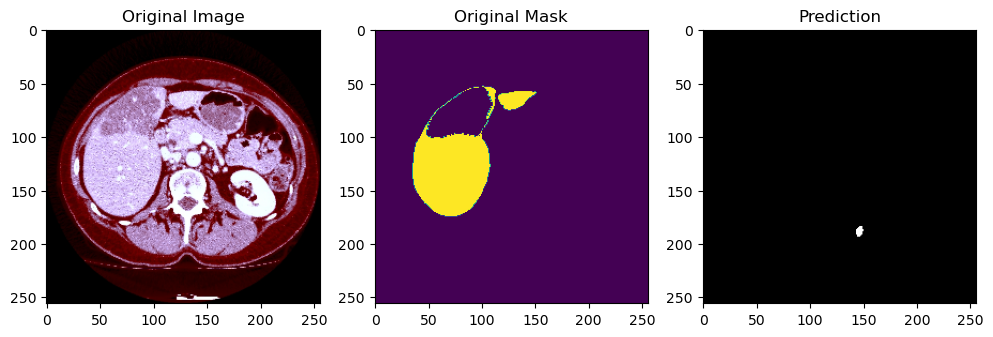

1/1 [==============================] - 0s 466ms/step


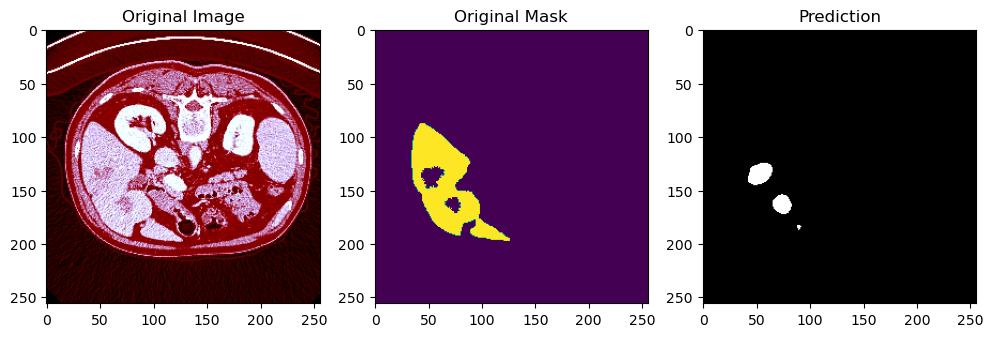

1/1 [==============================] - 0s 484ms/step


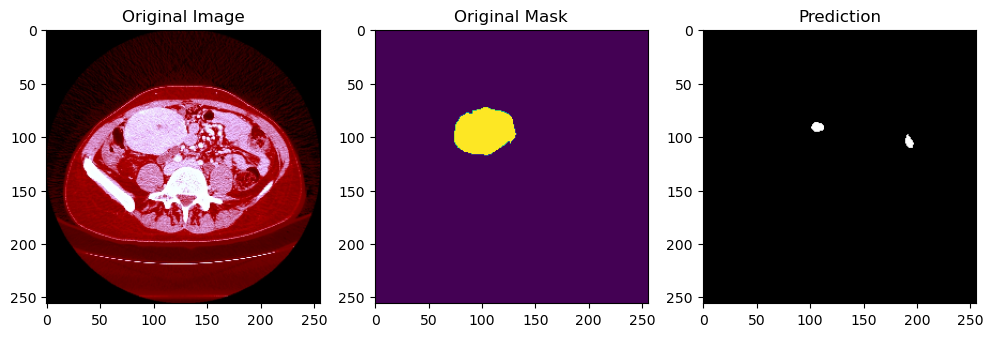

1/1 [==============================] - 0s 463ms/step


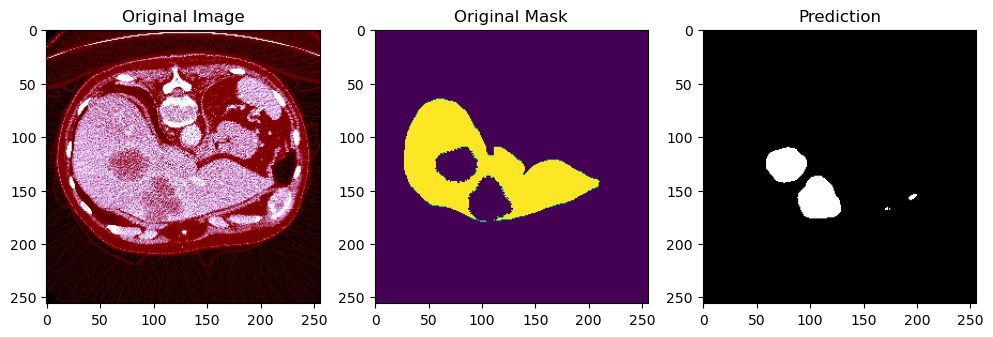

1/1 [==============================] - 0s 454ms/step


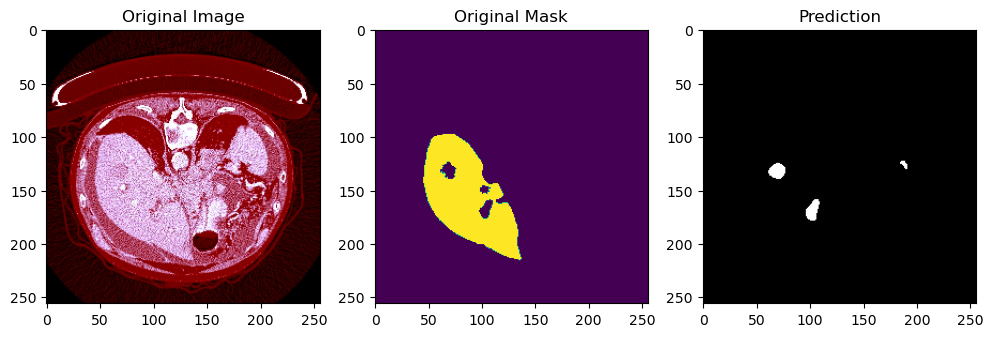

1/1 [==============================] - 1s 501ms/step


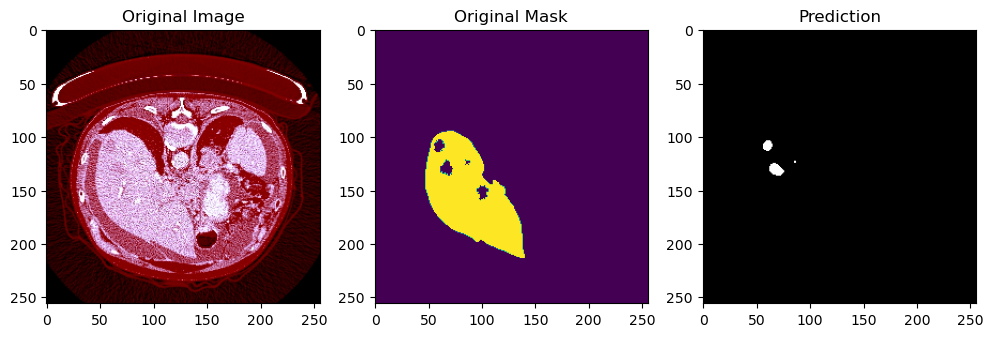

In [36]:
for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE, interpolation = cv2.INTER_NEAREST)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(adjust_mask(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .30,cmap='gray')
    plt.title('Prediction')
    plt.show()

In [30]:
cor , incor = 0 , 0
for i in range(len(df_test.index)):
    index=i
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred = (np.squeeze(model.predict(img)) > 0.30)
    mask = np.squeeze(adjust_mask(df_test['mask_path'].iloc[index]))
    if pred.any() == mask.any():
        cor += 1
    else:
        incor += 1

1/1 [==============================] - 1s 506ms/step


1/1 [==============================] - 1s 535ms/step


In [31]:
print("Correct = " , cor , "Incorrect = " , incor )
print("Accuracy = " , (cor/(cor+incor)) * 100)

Correct =  186 Incorrect =  14
Accuracy =  93.0
